In [10]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from mip import *

In [11]:
# 读取女性评分
with open("Scores_for_Women.txt", "r") as f:
    w_to_m_data = f.readlines()[1:]

# 转化为矩阵 w_to_m_score_matrix[i][j] 为 女性i对男性j的评分
w_to_m_Scores = []    
for i in range(len(w_to_m_data)):
    w_to_m_Scores.append([float(ii) for ii in w_to_m_data[i].strip('\n').split(' ')[:-1]])
    
w_to_m_score_matrix = np.array(w_to_m_Scores)

# 读取男性评分
with open("Scores_for_Men.txt", "r") as f:
    m_to_w_data = f.readlines()[1:]

# 转化为矩阵 m_to_w_score_matrix[i][j] 为 男性i对女性j的评分    
m_to_w_Scores = []    
for i in range(len(m_to_w_data)):
    m_to_w_Scores.append([float(ii) for ii in m_to_w_data[i].strip('\n').split(' ')[:-1]])
    
m_to_w_score_matrix = np.array(m_to_w_Scores)


# 读取拒绝列表
with open("Reject_List.txt", "r") as f:
    reject_data = f.readlines()[1:]

# 转化为列表 
reject_list = []    
for i in range(len(reject_data)):
    reject_list.append([int(ii) for ii in reject_data[i].strip('\n').split(' ')])
    
# print('reject_list', reject_list)

W_dict = {} # 女性可接受词典
M_dict = {} # 男性可接受词典

for i in range(68):
    W_dict[i] = [i for i in range(68)]
    M_dict[i] = [i for i in range(68)]

for j in reject_list: # 按拒绝列表移除不接受的用户
    W_dict[j[0]].remove(j[1])
    M_dict[j[1]].remove(j[0])


In [16]:
    
# 模型一： 最大化匹配总权重
def OneSideMatching1(score_matrix, X, sex_side): 
    # X: 每名用户(默认女性)可被推荐的最大次数
    # score_matrix： 用户的分数矩阵，为男性推荐则input为 m_to_w_score_matrix，为女性推荐则input为 w_to_m_score_matrix
    # sex_side： 为哪种性别的用户推荐， male为男性 female为女性
    
    OSM1 = Model(sense=MAXIMIZE, solver_name=CPLEX) # 生成模型 调用Cplex求解器
    OSM1.verbose = 0

    # 创建男女全集合，根据数据不同需要变动
    num_female = 68
    num_male = 68

    I = set(range(num_female))
    J = set(range(num_male))
    
    # 添加二元变量

    x = [[OSM1.add_var(var_type=BINARY) for j in J] for i in I] # Decision Variable
    
    # 设定目标方程
    
    OSM1.objective = xsum(score_matrix[i][j]*x[i][j] for i in I for j in W_dict[i])
    
    # 根据不同性别添加约束
    if sex_side == 'male':
        for i in I:
            OSM1 += xsum(x[i][j] for j in W_dict[i]) <= X 

        for j in J:
            OSM1 += xsum(x[i][j] for i in M_dict[j]) <= 1 
            
    if sex_side == 'female':
        for i in I:
            OSM1 += xsum(x[i][j] for j in W_dict[i]) <= 1 

        for j in J:
            OSM1 += xsum(x[i][j] for i in M_dict[j]) <= X
    
    
    start = time.perf_counter()
    status = OSM1.optimize(max_seconds=600)
    end = time.perf_counter()
    runningtime = end-start
    
    
    # 根据不同性别进行解的收集
    solution = []
    
    if sex_side == 'male':
        for i in I:
            for j in J:
                if x[i][j].x > 0.99:
                    solution.append([i,j])
    
    
    if sex_side == 'female':
        for j in J:
            for i in I:
                if x[i][j].x > 0.99:
                    solution.append([i,j])
    
    return solution, OSM1.objective_value, runningtime # 匹配结果，模型最优值, 运行时间

In [17]:

# 最大化最小权重
def OneSideMatching2(score_matrix, X, sex_side):
    # X: 每名用户(默认女性)可被推荐的最大次数
    # score_matrix： 用户的分数矩阵，为男性推荐则input为 m_to_w_score_matrix，为女性推荐则input为 w_to_m_score_matrix
    # sex_side： 为哪种性别的用户推荐， male为男性 female为女性
    
    
    OSM2 = Model(sense=MAXIMIZE, solver_name=CPLEX) # 生成模型 调用Cplex求解器
    OSM2.verbose = 0
    # 创建男女全集合，根据数据不同需要变动         
    num_female = 68
    num_male = 68

    I = set(range(num_female))
    J = set(range(num_male))

    # 添加决策变量
    x = [[OSM2.add_var(var_type=BINARY) for j in J] for i in I]
    z = OSM2.add_var()

    # 设定目标方程
    OSM2.objective = z

    # 根据不同性别添加约束
    if sex_side == 'male':
        for i in I:
            OSM2 += xsum(x[i][j] for j in W_dict[i]) <= X 

        for j in J:
            OSM2 += xsum(x[i][j] for i in M_dict[j]) <= 1 
            OSM2 += xsum(score_matrix[i][j]*x[i][j] for i in M_dict[j]) >= z 
            
    if sex_side == 'female':
        for i in I:
            OSM2 += xsum(x[i][j] for j in W_dict[i]) <= 1 
            OSM2 += xsum(score_matrix[i][j]*x[i][j] for j in W_dict[i]) >= z 
            
        for j in J:
            OSM2 += xsum(x[i][j] for i in M_dict[j]) <= X

    start = time.perf_counter()
    status = OSM2.optimize(max_seconds=600)
    end = time.perf_counter()
    runningtime = end-start
        
    
    # 根据不同性别进行解的收集
    solution = []
    
    if sex_side == 'male':
        for i in I:
            for j in J:
                if x[i][j].x > 0.99:
                    solution.append([i,j])
    
    
    if sex_side == 'female':
        for j in J:
            for i in I:
                if x[i][j].x > 0.99:
                    solution.append([i,j])
    
    return solution, OSM2.objective_value, runningtime # 匹配结果，模型最优值，运行时间

In [18]:
solution1, obj_value1, runtime1 = OneSideMatching1(m_to_w_score_matrix, 4, sex_side='male')
solution2, obj_value2, runtime2 = OneSideMatching2(w_to_m_score_matrix, 4, sex_side='male')

print(f"Runing time for OneSideMatching1: {runtime1}")
print(f"Runing time for OneSideMatching2: {runtime2}")

Runing time for OneSideMatching1: 0.2634780560000536
Runing time for OneSideMatching2: 0.3929436359999272


In [21]:
# matching for men for OneSideMatching1
print(solution1)

[[2, 58], [2, 67], [4, 60], [5, 29], [5, 37], [5, 62], [6, 39], [6, 41], [6, 59], [6, 61], [8, 48], [11, 47], [11, 63], [13, 5], [13, 32], [13, 35], [13, 65], [14, 42], [14, 46], [15, 21], [15, 22], [15, 23], [15, 27], [18, 1], [18, 26], [19, 0], [19, 9], [19, 18], [19, 55], [22, 8], [22, 53], [23, 3], [23, 30], [23, 52], [24, 36], [24, 50], [26, 17], [26, 31], [27, 12], [27, 24], [27, 34], [27, 57], [33, 49], [33, 66], [38, 2], [38, 19], [38, 20], [38, 25], [45, 15], [49, 54], [49, 64], [51, 6], [53, 14], [53, 16], [53, 51], [54, 13], [56, 4], [56, 11], [56, 33], [56, 38], [60, 28], [64, 44], [65, 43], [65, 45], [66, 7], [66, 10], [66, 40], [66, 56]]


In [22]:
# matching for men for OneSideMatching2
print(solution2)

[[0, 3], [0, 29], [0, 44], [1, 31], [2, 13], [2, 65], [3, 7], [3, 41], [3, 57], [4, 19], [7, 4], [8, 10], [8, 48], [9, 9], [9, 45], [10, 66], [11, 35], [13, 20], [14, 53], [15, 67], [17, 28], [18, 8], [18, 33], [20, 12], [20, 30], [20, 52], [20, 59], [25, 6], [28, 40], [28, 43], [29, 39], [29, 55], [29, 56], [30, 42], [30, 49], [31, 15], [31, 27], [31, 46], [31, 62], [35, 5], [35, 26], [37, 22], [37, 24], [37, 34], [37, 36], [38, 18], [38, 37], [38, 58], [42, 14], [45, 11], [45, 64], [47, 17], [47, 47], [48, 54], [48, 63], [49, 0], [49, 25], [49, 61], [52, 50], [52, 51], [54, 23], [55, 2], [55, 32], [56, 1], [56, 16], [60, 38], [62, 21], [62, 60]]


## Evaluation

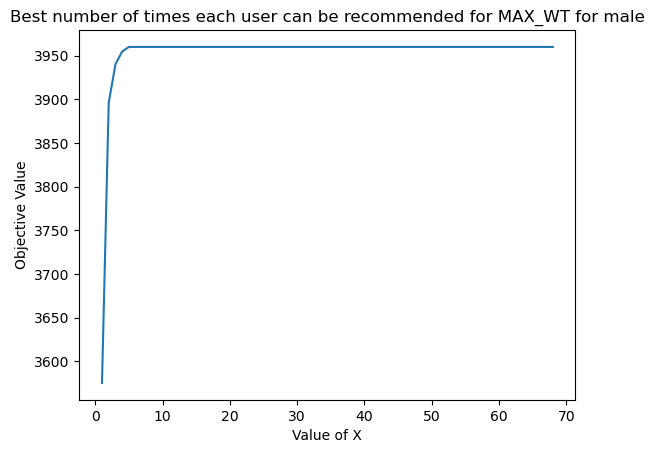

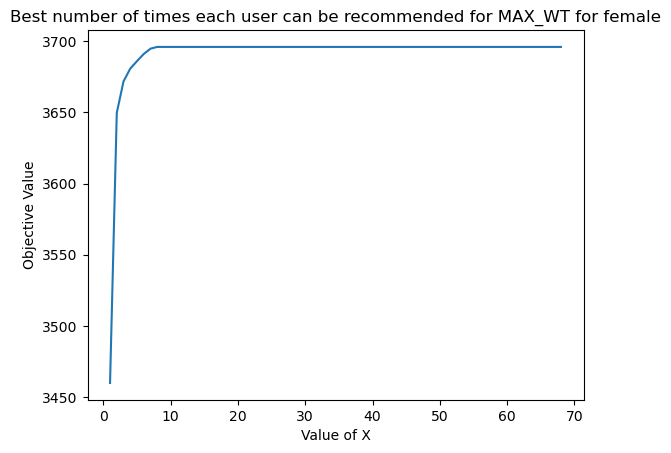

In [19]:
# find the best X according to the objective value

def plot_best_X(algorithm, score_matrix, sex_side, max_X=68, algo_name='MAX_WT'):
    """
    Compute and plot the best number of recommendations (X) for a given algorithm and sex side.

    """
    results = []

    # Find the best X according to the objective value
    for X in range(1, max_X + 1):
        obj_value = algorithm(score_matrix, X, sex_side)[1]
        results.append((X, obj_value))

    # Plot the results
    X_values, obj_values = zip(*results)
    plt.plot(X_values, obj_values)
    plt.xlabel('Value of X')
    plt.ylabel('Objective Value')
    plt.title(f'Best number of times each user can be recommended for {algo_name} for {sex_side}')
    filename = f'Best number of times each user can be recommended for {algo_name} for {sex_side}.png'
    plt.savefig(filename,bbox_inches='tight')
    plt.show()


plot_best_X(OneSideMatching1, m_to_w_score_matrix, 'male', algo_name='MAX_WT')
plot_best_X(OneSideMatching1, w_to_m_score_matrix, 'female', algo_name='MAX_WT')

Mean score for OneSideMatching1: 58.233823529411765
Standard deviation for OneSideMatching1: 10.91033792400203
Mean score for OneSideMatching2: 42.21985294117647
Standard deviation for OneSideMatching2: 6.365117135987702


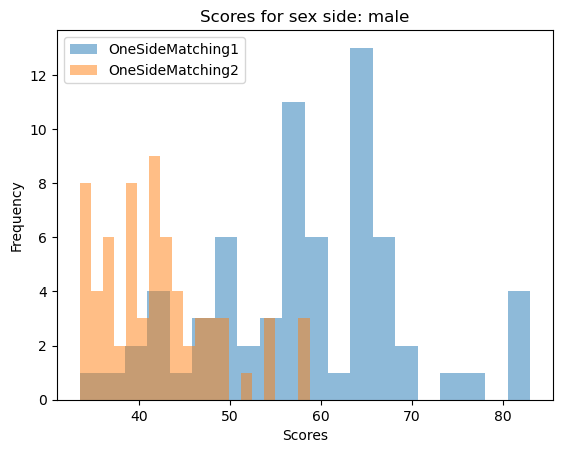

Mean score for OneSideMatching1: 54.35367647058823
Standard deviation for OneSideMatching1: 12.31824124483349
Mean score for OneSideMatching2: 34.29926470588235
Standard deviation for OneSideMatching2: 10.48998644593086


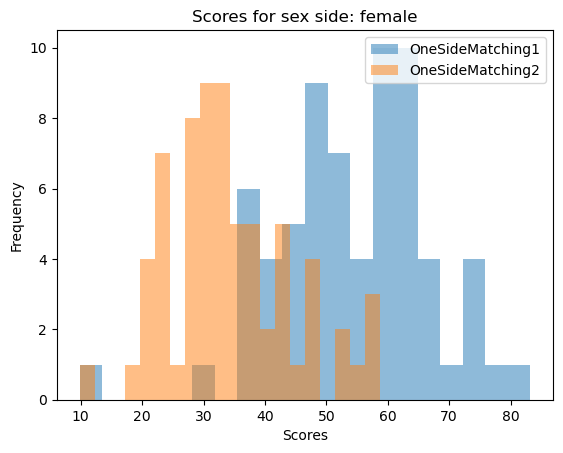

In [20]:
# compare scores of the algorithms

def evaluate_algorithms(algorithms, score_matrix, X, sex_side):
    """
    Evaluate and compare results of different algorithms based on the sex side.
    
    Returns:
    - A histogram comparing the scores of the algorithms.
    - Mean and standard deviation of scores for each algorithm.
    """
    
    for algorithm in algorithms:
        solution = algorithm(score_matrix, X, sex_side=sex_side)[0]
        scores = [score_matrix[pair[0]][pair[1]] for pair in solution]
        
        # Plot histogram
        plt.hist(scores, bins=20, alpha=0.5, label=algorithm.__name__)
        
        # Print mean and standard deviation
        print(f"Mean score for {algorithm.__name__}: {np.mean(scores)}")
        print(f"Standard deviation for {algorithm.__name__}: {np.std(scores)}")
    
    plt.legend()
    plt.xlabel('Scores')
    plt.ylabel('Frequency')
    plt.title(f"Scores for sex side: {sex_side}")
    plt.savefig(f"Scores for sex side: {sex_side}", bbox_inches='tight')
    plt.show()

evaluate_algorithms([OneSideMatching1, OneSideMatching2], m_to_w_score_matrix, 10, sex_side='male')
evaluate_algorithms([OneSideMatching1, OneSideMatching2], w_to_m_score_matrix, 10, sex_side='female')